In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
num_epochs = 5
batch_size = 4
learning_rate = 0.001

In [4]:
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform = transforms.Compose([transforms.ToTensor()])

In [5]:
train_dataset = torchvision.datasets.MNIST(root = './data', train = True, 
                                           download = True, transform = transform)
test_dataset = torchvision.datasets.MNIST(root = './data', train = True, 
                                           download = True, transform = transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True )
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size)

In [7]:
classes = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

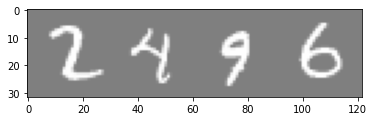

In [8]:
def imshow(img):
  img = (img / 2) + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

data_iter = iter(train_loader)
images, labels = data_iter.next()

imshow(torchvision.utils.make_grid(images))

In [9]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, 5, stride= 1, padding= 0)   
    self.pool = nn.MaxPool2d(2, 2)                           
    self.conv2 = nn.Conv2d(6, 16, 5, stride= 1, padding= 0) 
    self.fc1 = nn.Linear(16*4*4, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    # conv1: [4, 1, 28, 28] to [4, 6, 24, 24]   -> Here 1 is the no of input channels of conv1 and 6 is no of output channels of conv1
    # MaxPool: [4, 6, 24, 24] to [4, 6, 12, 12]
    x = self.pool(F.relu(self.conv2(x)))
    # conv2: [4, 6, 12, 12] to [4, 16, 8, 8]    -> Here 6 is the no of input channels of conv1 and 16 is no of output channels of conv1
    # MaxPool: [4, 16, 8, 8] to [4, 16, 4, 4]     
    x = x.view(-1, 16*4*4)  
    x = F.relu(self.fc1(x)) #To flatten the 3D tensor to 1D, we pass it through fc1 with input size as 16*4*4 and output size as 120
    x = F.relu(self.fc2(x)) #We further reduce 120 to 84
    x = self.fc3(x) # Finally we reduce 84 to 10 (ie the no of classes)
    return x

In [10]:
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [11]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    #Forward Pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    #Backward Pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 2000 == 0:
      print(f'Epoch [{epoch +1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss = {loss.item():.4f}')

Epoch [1/5], Step [2000/15000], Loss = 2.2984
Epoch [1/5], Step [4000/15000], Loss = 2.2755
Epoch [1/5], Step [6000/15000], Loss = 2.2494
Epoch [1/5], Step [8000/15000], Loss = 1.7576
Epoch [1/5], Step [10000/15000], Loss = 0.4802
Epoch [1/5], Step [12000/15000], Loss = 0.1581
Epoch [1/5], Step [14000/15000], Loss = 0.3311
Epoch [2/5], Step [2000/15000], Loss = 0.7128
Epoch [2/5], Step [4000/15000], Loss = 0.0397
Epoch [2/5], Step [6000/15000], Loss = 0.0146
Epoch [2/5], Step [8000/15000], Loss = 0.4999
Epoch [2/5], Step [10000/15000], Loss = 0.0723
Epoch [2/5], Step [12000/15000], Loss = 0.0306
Epoch [2/5], Step [14000/15000], Loss = 0.0777
Epoch [3/5], Step [2000/15000], Loss = 0.0558
Epoch [3/5], Step [4000/15000], Loss = 0.0051
Epoch [3/5], Step [6000/15000], Loss = 0.0613
Epoch [3/5], Step [8000/15000], Loss = 0.2554
Epoch [3/5], Step [10000/15000], Loss = 0.3556
Epoch [3/5], Step [12000/15000], Loss = 0.0042
Epoch [3/5], Step [14000/15000], Loss = 0.0079
Epoch [4/5], Step [2000/1

In [12]:
print('Finished Training')
PATH = './mnist.pth'
torch.save(model.state_dict(), PATH)

Finished Training


In [13]:
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(10)]
  n_class_samples = [0 for i in range(10)]
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()

    for i in range(batch_size):
      label = labels[i]
      pred = predicted[i]
      if (label == pred):
        n_class_correct[label] += 1
      n_class_samples[label] +=1
  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy of the network: {acc} %')
  for i in range(10):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 97.325 %
Accuracy of 0: 98.24413304068884 %
Accuracy of 1: 98.82824087807772 %
Accuracy of 2: 96.91171534071836 %
Accuracy of 3: 98.62991355406949 %
Accuracy of 4: 97.87743923313934 %
Accuracy of 5: 94.65043349935436 %
Accuracy of 6: 98.91855356539371 %
Accuracy of 7: 95.96169193934557 %
Accuracy of 8: 97.43633566911639 %
Accuracy of 9: 95.41099344427634 %
